In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-iot/test_ML_IOT.csv
/kaggle/input/ml-iot/sample_submission_ML_IOT.csv
/kaggle/input/ml-iot/train_ML_IOT.csv


In [2]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import time
from scipy.signal import find_peaks
from scipy.stats import gamma
import statsmodels.api as sm
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [3]:
train = pd.read_csv("../input/ml-iot/train_ML_IOT.csv")

In [4]:
train['DateTime'] = pd.to_datetime(train['DateTime'])

train['Weekday'] = [datetime.weekday(date) for date in train.DateTime]
train['Year'] = [date.year for date in train.DateTime]
train['Month'] = [date.month for date in train.DateTime]
train['Day'] = [date.day for date in train.DateTime]
train['Hour'] = [date.hour for date in train.DateTime]
train['Week'] = [date.week for date in train.DateTime]
train['Quarter'] = [date.quarter for date in train.DateTime]
train["IsWeekend"] = train["Weekday"] >= 5

In [5]:
j1=train[train["Junction"]==1]
j2=train[train["Junction"]==2]
j3=train[train["Junction"]==3]
j4=train[train["Junction"]==4]

js = [j1, j2, j3, j4]

In [6]:
def outlier_detection(j, std_param = 3, window_length = 720, alpha = 0.04):
    
    rmeans = j.rolling(window_length, min_periods=1).median()
    rstd = j.rolling(window_length, min_periods=1).std()
    rstd_lower = j[j<rmeans].rolling(window_length ,min_periods=1).std()
    
    kurt = j.kurt()
    
    upper = rmeans+std_param*rstd*np.exp(alpha*kurt)
    lower = rmeans - (5*rstd_lower)    
    idx1 = (j>upper)
    idx2 = (j<lower)
    
    idx = idx1 | idx2
    
    return j, idx, rmeans, upper, lower

In [7]:
jads = [j1, j2, j3, j4]
for i,j in enumerate(js):
    jads[i] = j.Vehicles
    jads[i].index = j.DateTime

In [8]:
for j in jads:
    j, idx, rmeans, upper, lower = outlier_detection(j)
    j[idx] = np.nan

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [9]:
j1 = j1.interpolate(method="ffill")
j2 = j2.interpolate(method="ffill")
j3 = j3.interpolate(method="ffill")
j4 = j4.interpolate(method="ffill")

In [10]:
j1 = j1.Vehicles.to_numpy()
j2 = j2.Vehicles.to_numpy()
j3 = j3.Vehicles.to_numpy()
j4 = j4.Vehicles.to_numpy()

In [11]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [12]:
js = [j1, j2, j3, j4]

In [13]:
def data_prep(j, look_back):
    train_size = int(len(j) * 0.85)
    test_size = len(j) - train_size
    j_train, j_test = j[0:train_size], j[train_size:len(j)]

    j_train = j_train.reshape(-1,1)
    j_test = j_test.reshape(-1,1)

    scaler = StandardScaler()
    scaler.fit(j_train)

    j_train = scaler.transform(j_train)
    j_test= scaler.transform(j_test)

    X_train, Y_train = create_dataset(j_train, look_back)
    X_test, Y_test = create_dataset(j_test, look_back)

    X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
    
    return X_train, Y_train, X_test, Y_test, scaler

In [14]:
def model(X_train, Y_train, X_test, Y_test):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

    #model.summary()
    
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    return train_predict, test_predict

In [15]:
look_back = [12,24,48,72,168]

In [16]:
for k, m in enumerate(look_back):
    print("look back = ", str(look_back[k]))

look back =  12
look back =  24
look back =  48
look back =  72
look back =  168


2022-07-24 12:51:56.647835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 12:51:56.652602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 12:51:56.653303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-24 12:51:56.654953: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

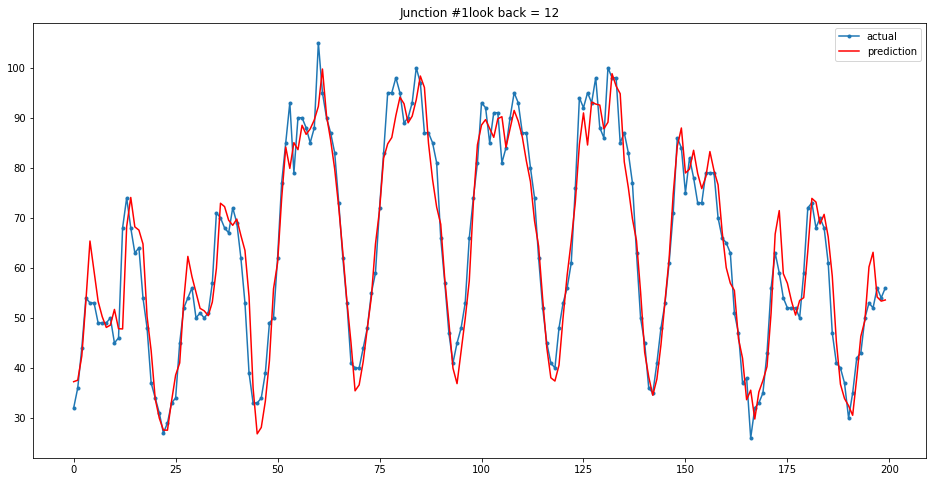

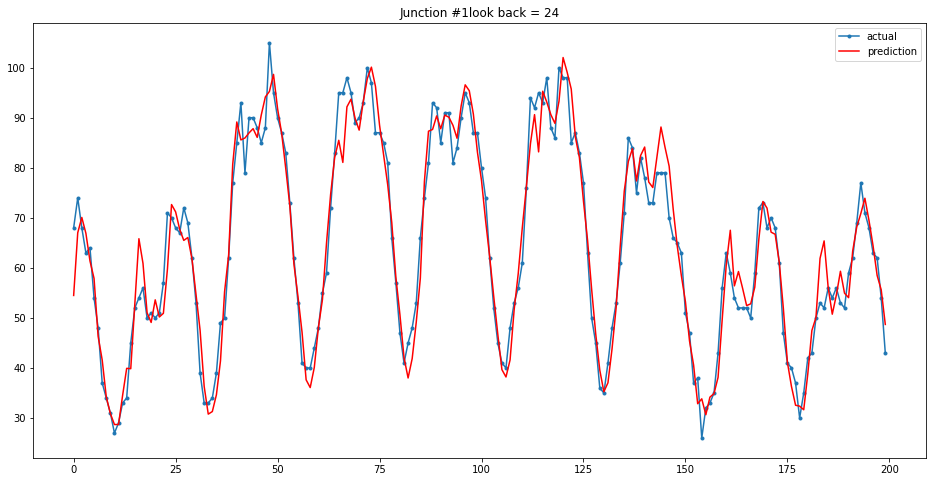

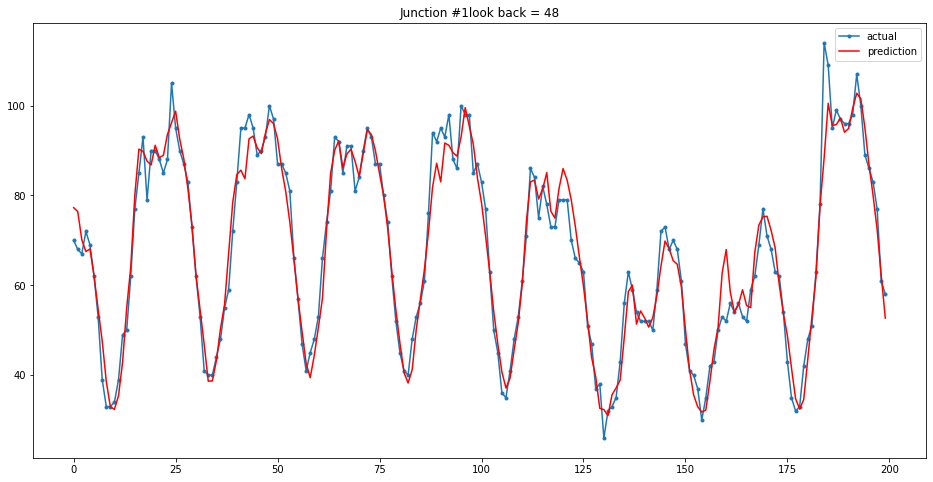

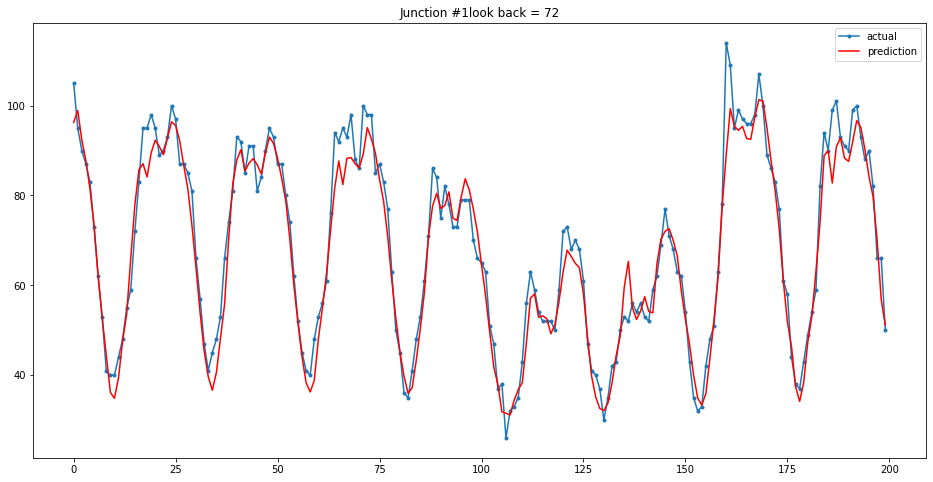

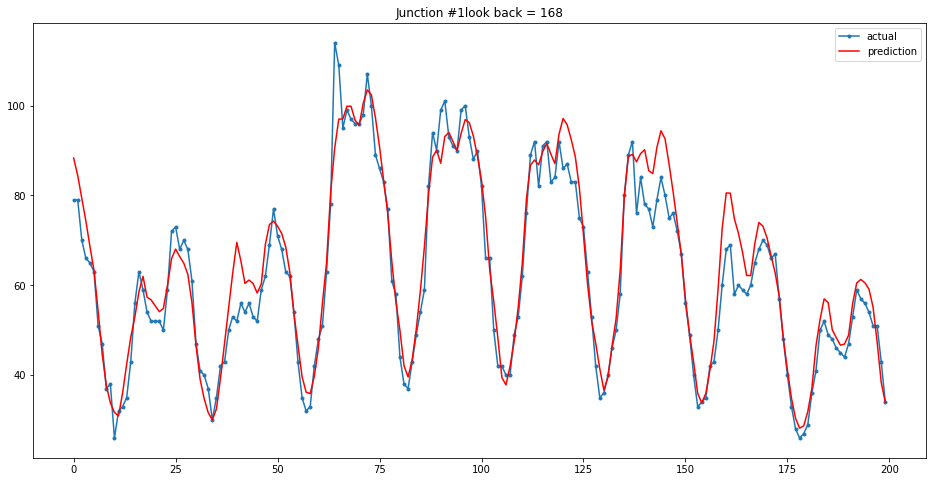

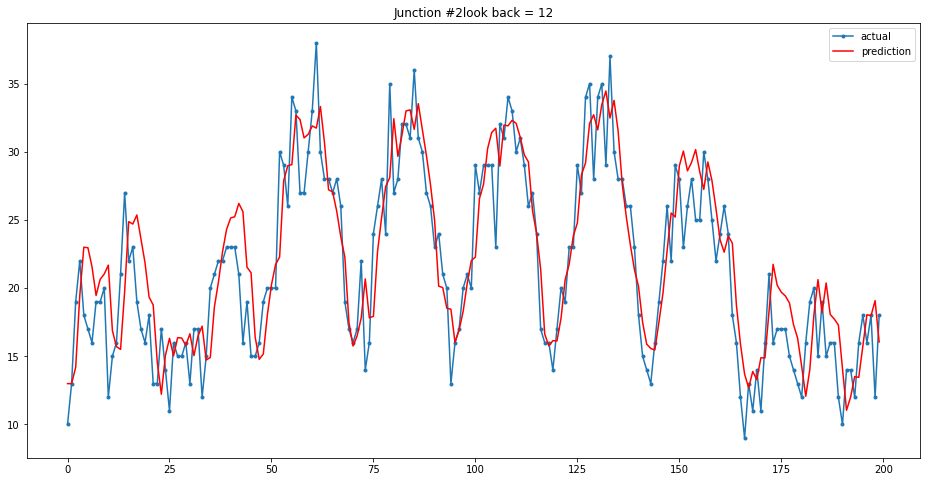

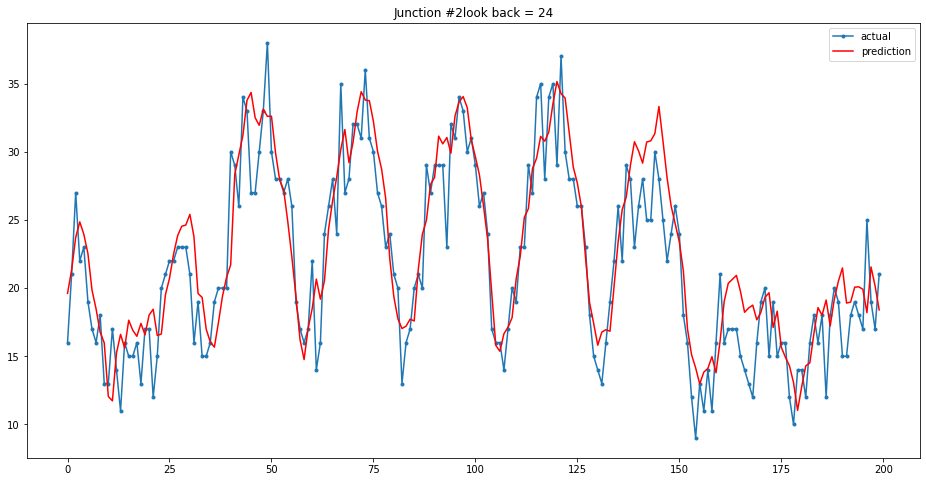

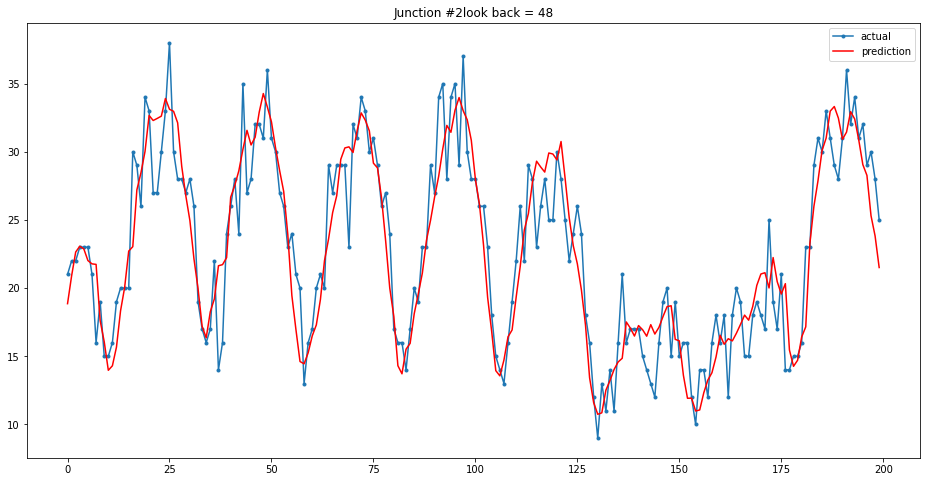

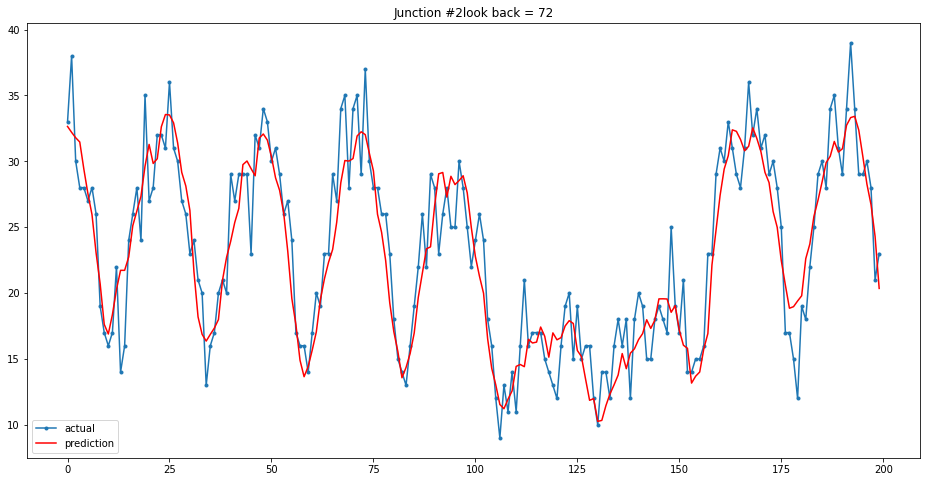

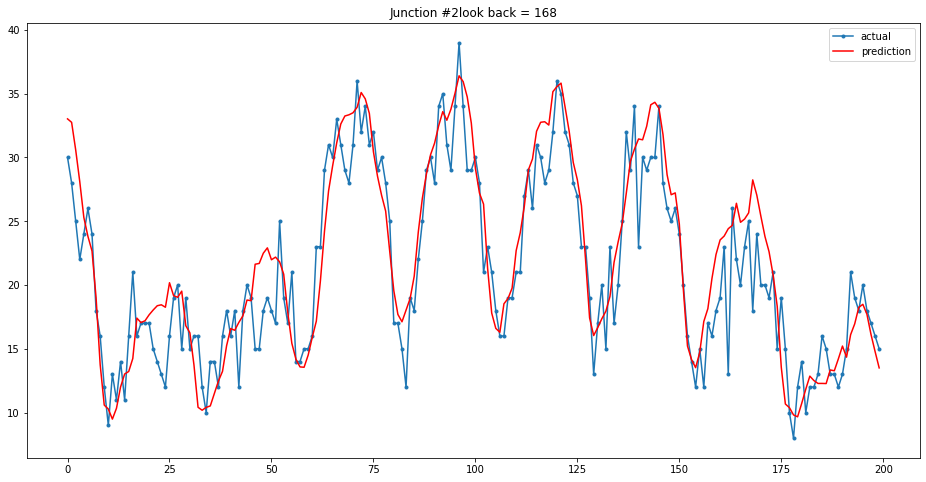

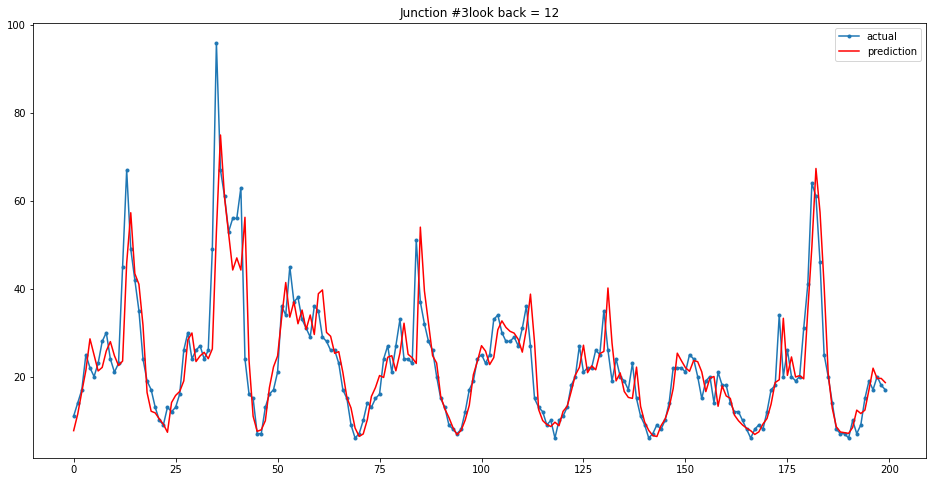

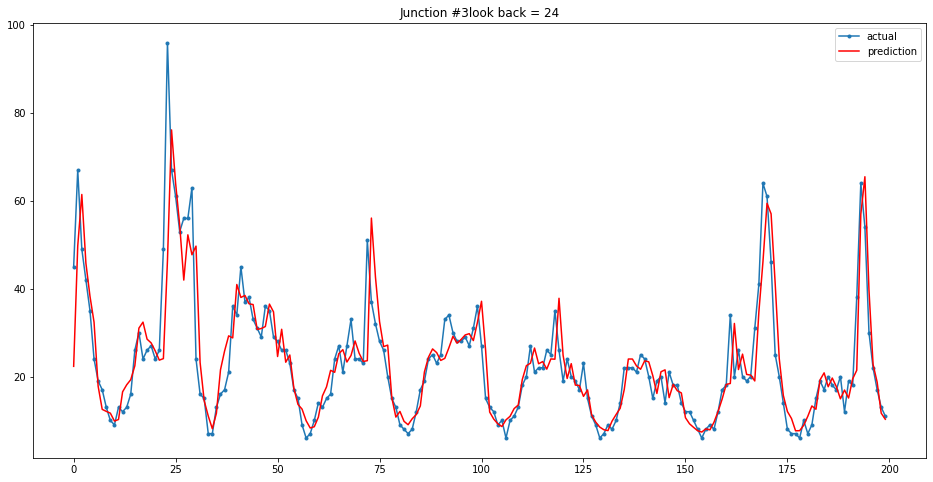

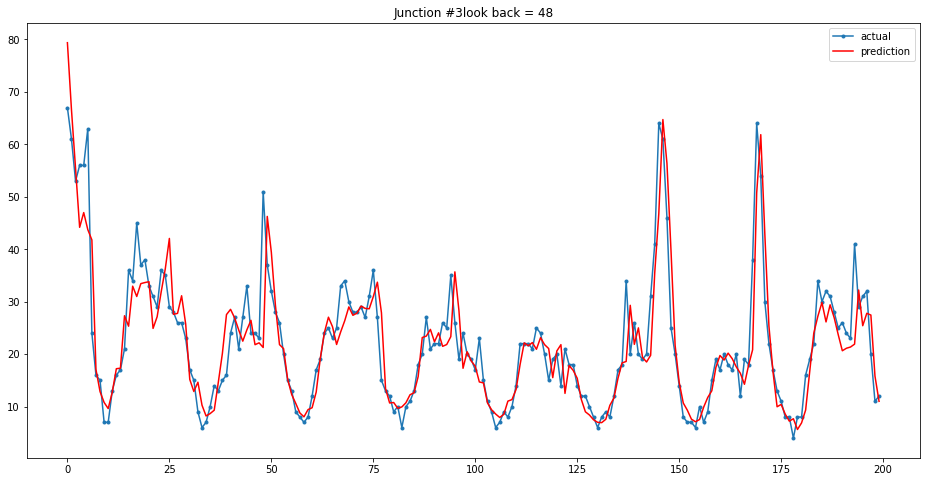

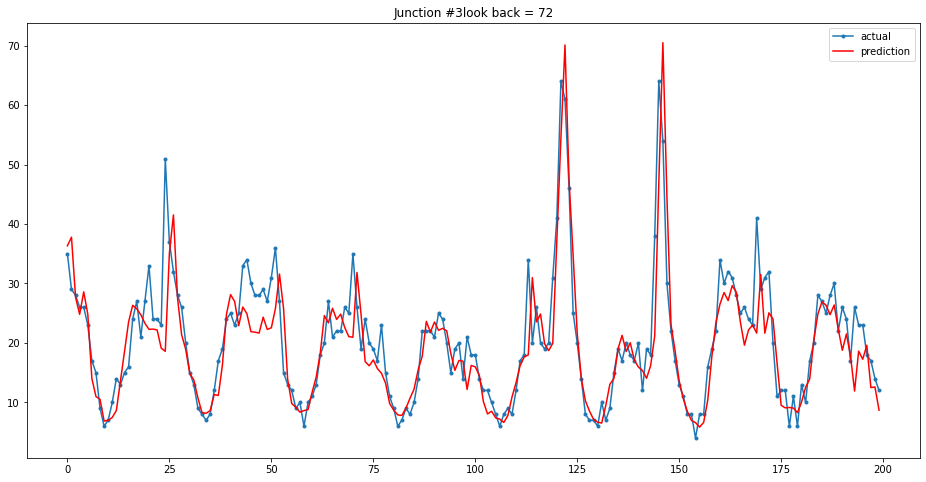

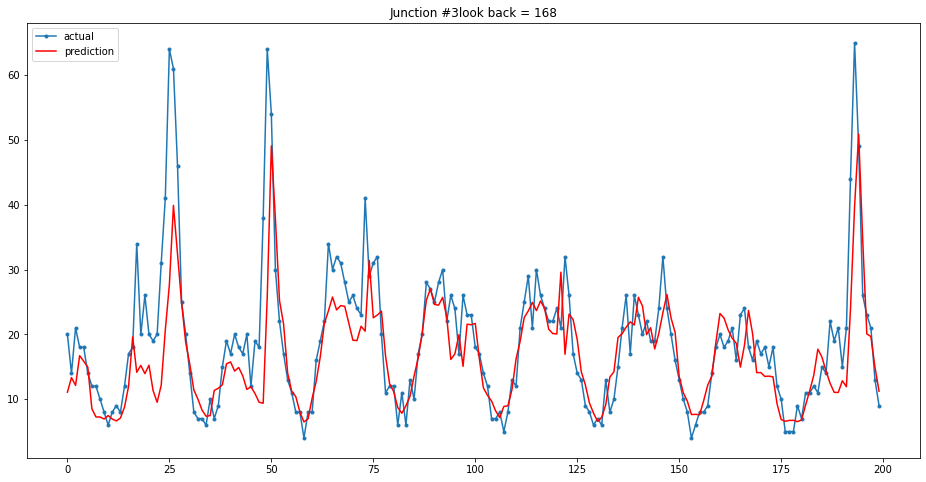

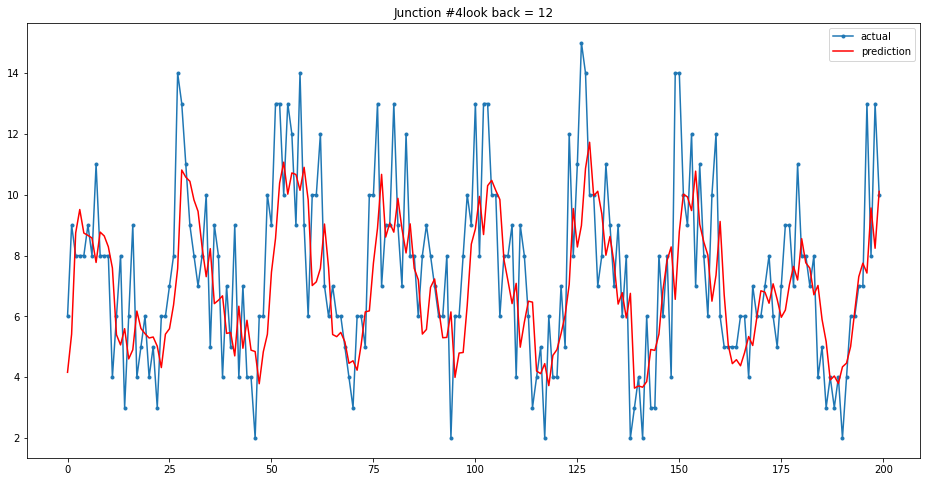

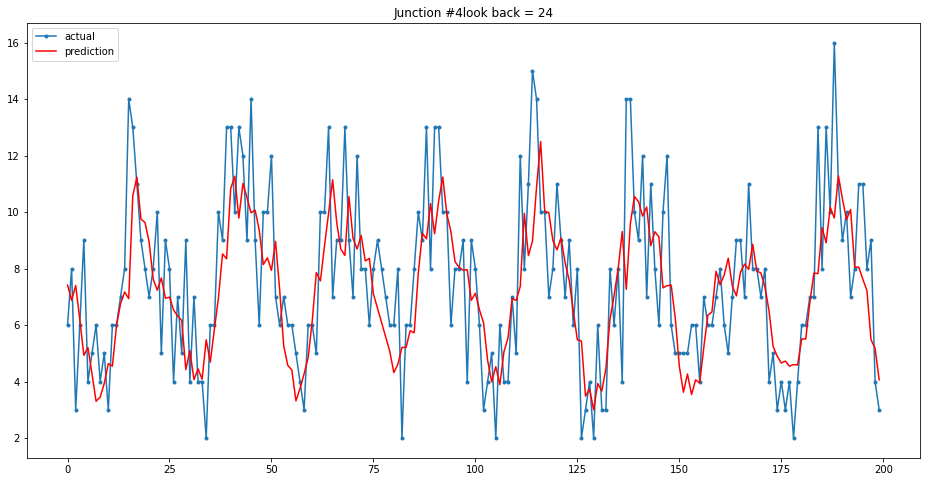

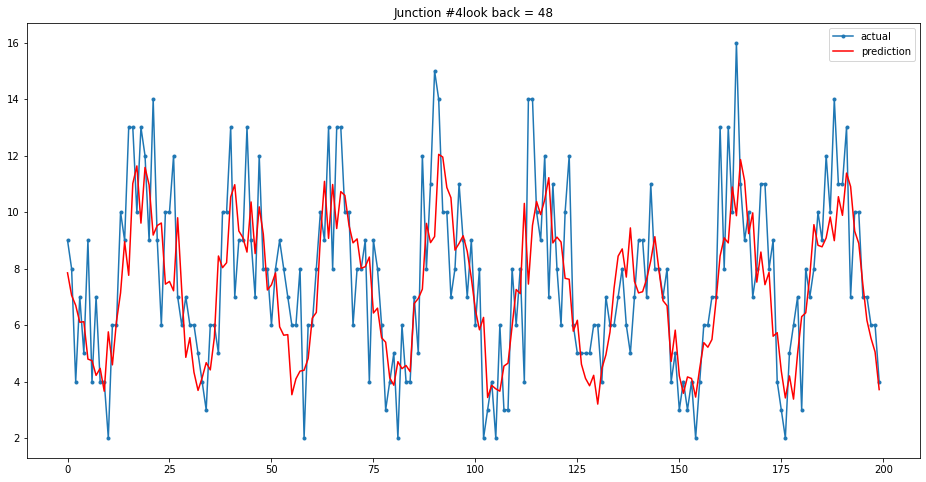

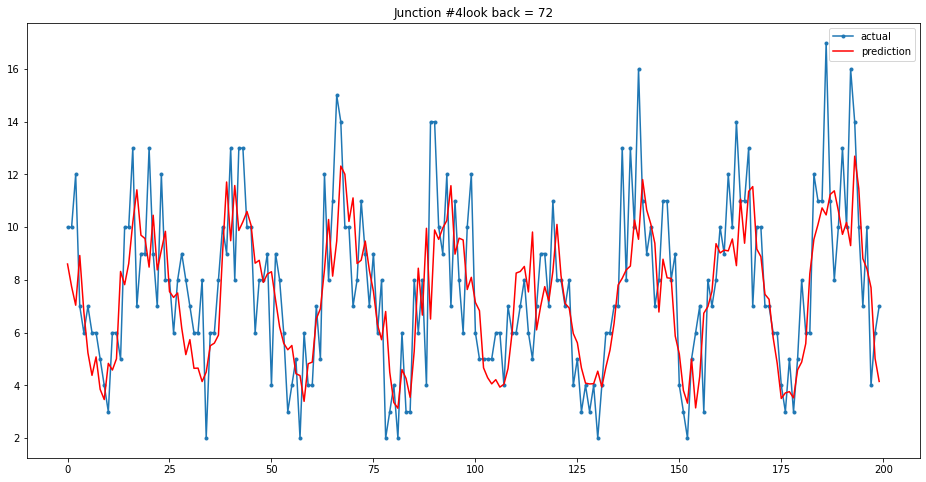

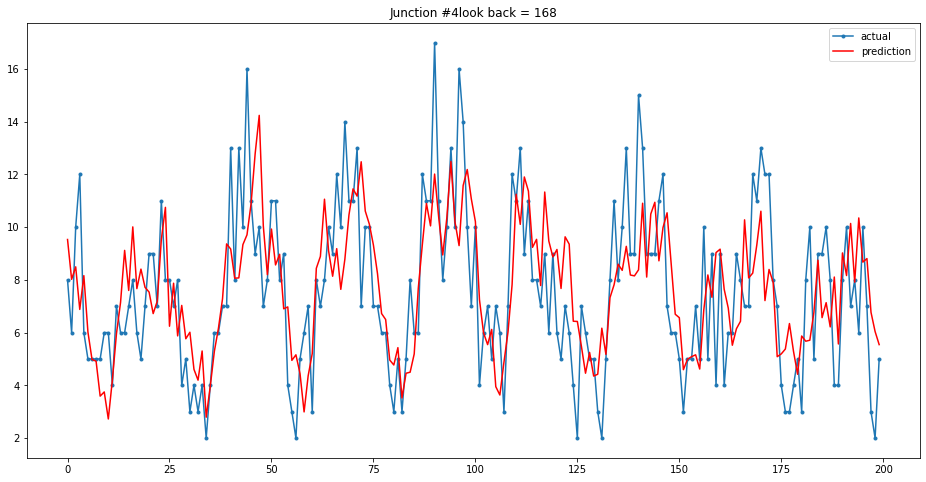

In [17]:
mae_mat = np.zeros((len(js),len(look_back)))
mape_mat = np.zeros((len(js),len(look_back)))
r2_mat = np.zeros((len(js),len(look_back)))

for i,j in enumerate(js):
    for k, m in enumerate(look_back):
        X_train, Y_train, X_test, Y_test, scaler = data_prep(j,m)
        train_predict, test_predict = model(X_train, Y_train, X_test, Y_test)

        train_predict = scaler.inverse_transform(train_predict)
        Y_train = scaler.inverse_transform([Y_train])
        test_predict = scaler.inverse_transform(test_predict)
        Y_test = scaler.inverse_transform([Y_test])

        mae_mat[i][k] = mean_absolute_error(Y_test[0], test_predict[:,0])
        mape_mat[i][k] = np.mean(np.abs(Y_test[0] - test_predict[:,0])/(Y_test[0]))*100
        r2_mat[i][k] = r2_score(Y_test[0],test_predict[:,0])
    
    
        plt.figure(figsize=(16,8))
        plt.plot(Y_test[0][:200], marker='.', label="actual")
        plt.plot(test_predict[:,0][:200], 'r', label="prediction")
        plt.title('Junction #' + str(i+1) + "look back = " + str(look_back[k]))
        plt.legend()

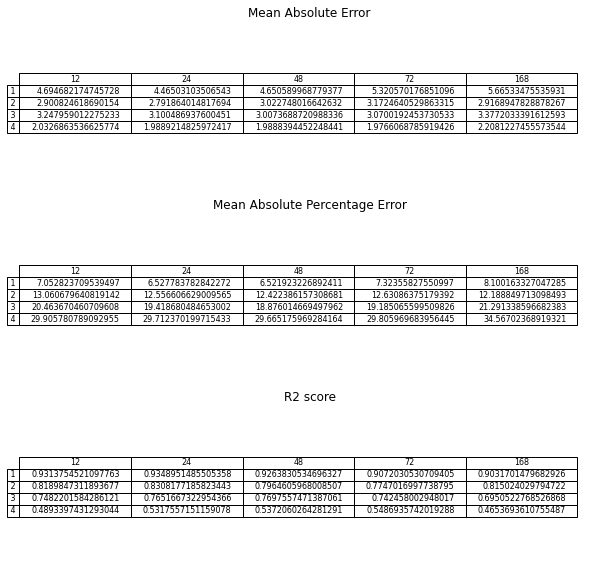

In [18]:
fig, axs = plt.subplots(3, 1,figsize=(10,10))
axs[0].axis("off")
axs[0].title.set_text('Mean Absolute Error')
the_table = axs[0].table(cellText=mae_mat, loc='center right',
                         rowLabels=[" 1 "," 2 "," 3 "," 4 "],colLabels=look_back)
#the_table.scale(2, 2)

axs[1].axis("off")
axs[1].title.set_text('Mean Absolute Percentage Error')
the_table = axs[1].table(cellText=mape_mat, loc='center right',
                         rowLabels=[" 1 "," 2 "," 3 "," 4 "],colLabels=look_back)
#the_table.scale(2, 2)

axs[2].axis("off")
axs[2].title.set_text('R2 score')
the_table = axs[2].table(cellText=r2_mat, loc='center right',
                         rowLabels=[" 1 "," 2 "," 3 "," 4 "],colLabels=look_back)
#the_table.scale(2, 2)

plt.show()